---
syncID: d2d126173eeb4494a06e35aa34bd2196
title: "Measuring tree height from the ground and from the air"
description: "Compare tree height measured from the ground to a Lidar-based Canopy Height Model"
dateCreated: 2019-5-21
authors: Claire K. Lunch
contributors: 
estimatedTime: 60 minutes
packagesLibraries: neonUtilities, raster
topics: vegetation-structure, ecosystem-structure, canopy-height-model
languagesTool: R
dataProduct: DP1.10098.001, DP3.30015.001
code1: /R/veg-structure-chm/veg_structure_and_chm.ipynb
tutorialSeries: 
urlTitle: veg-structure-chm
---

## Comparing tree height measured from the ground to a Lidar-based Canopy Height Model

This exercise uses the Canopy Height Model (CHM) and vegetation structure data 
from Wind River Experimental Forest in Washington State.

Start by loading packages and setting options.

In [ ]:
options(stringsAsFactors = F)
library(sp)
library(raster)
library(neonUtilities)
library(geoNEON)

### 1. Vegetation structure data

Download the vegetation structure data. If you haven't done this step yet, 
refer to the <a href="https://www.neonscience.org/neonDataStackR" target="_blank">tutorial</a> 
for the `neonUtilities` package.

In [ ]:
veglist <- loadByProduct(dpID="DP1.10098.001", site="WREF", package="basic")

Use the `geoNEON` package to get precise locations for the tagged plants, 
then merge the mapping and annual measurements tables.

In [ ]:
vegmap <- def.calc.geo.os(veglist$vst_mappingandtagging, 
                          "vst_mappingandtagging")
veg <- merge(veglist$vst_apparentindividual, vegmap, 
             by=c("individualID","namedLocation",
                  "domainID","siteID","plotID"))

Let's see what the data look like! Pick a plot, and make a stem map of 
the plants in it. Note that stemDiameter is in centimeters.

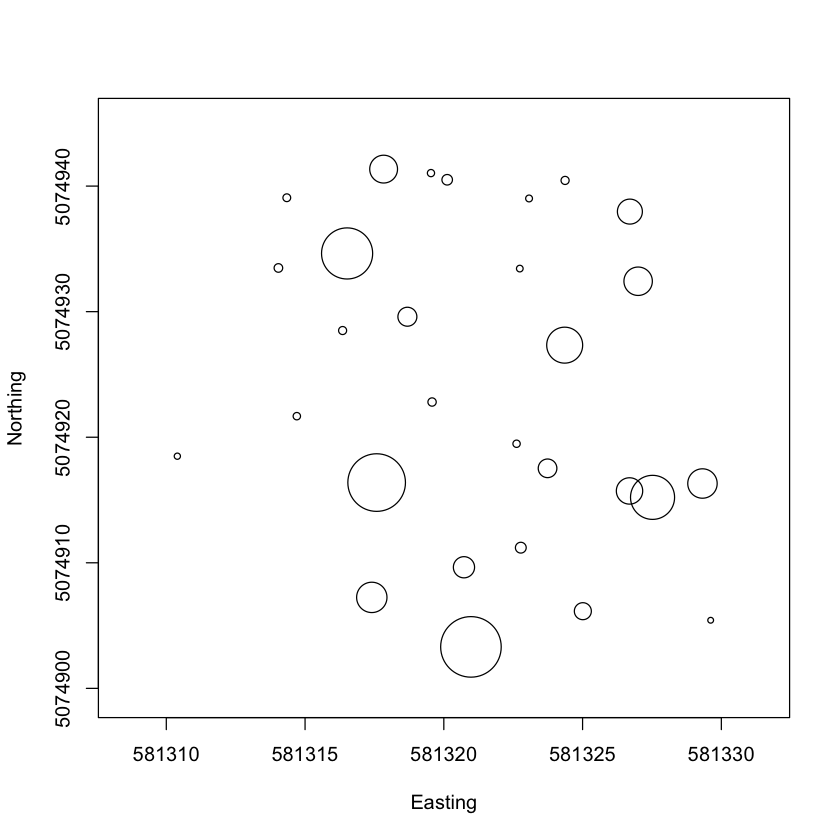

In [24]:
symbols(veg$adjEasting[which(veg$plotID=="WREF_081")], 
        veg$adjNorthing[which(veg$plotID=="WREF_081")], 
        circles=veg$stemDiameter[which(veg$plotID=="WREF_081")]/100, 
        inches=F, xlab="Easting", ylab="Northing")

And now overlay the estimated uncertainty in the location of each stem, 
in blue:

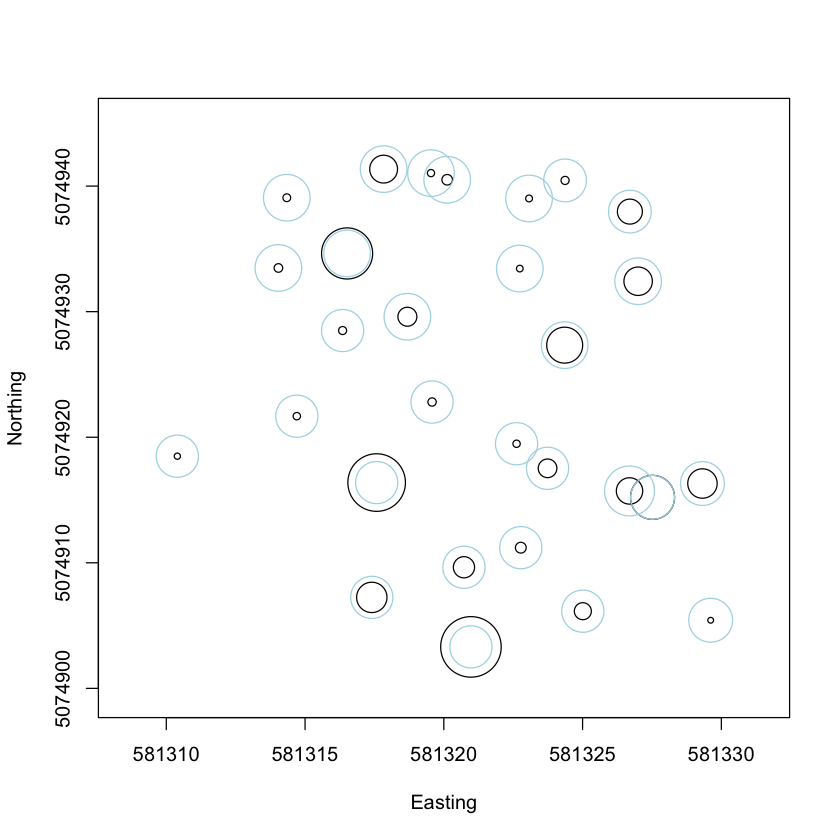

In [25]:
symbols(veg$adjEasting[which(veg$plotID=="WREF_081")], 
        veg$adjNorthing[which(veg$plotID=="WREF_081")], 
        circles=veg$stemDiameter[which(veg$plotID=="WREF_081")]/100, 
        inches=F, xlab="Easting", ylab="Northing")
symbols(veg$adjEasting[which(veg$plotID=="WREF_081")], 
        veg$adjNorthing[which(veg$plotID=="WREF_081")], 
        circles=veg$adjCoordinateUncertainty[which(veg$plotID=="WREF_081")], 
        inches=F, add=T, fg="lightblue")

### 2. Canopy height model data

Download the CHM tile at easting=580000 and northing=5075000, either 
from the data portal or using the `byTileAOP()` function. We could 
download all tiles that contain vegetation structure plots, but in 
this exercise we're sticking to one tile to limit download size and 
processing time.

Load the tile(s) into the environment using the `raster` package.

In [ ]:
byTileAOP(dpID="DP3.30015.001", site="WREF", year="2017", 
          easting=580000, northing=5075000,
          savepath="/data")
chm <- raster("/data/DP3.30015.001/2017/FullSite/D16/2017_WREF_1/L3/DiscreteLidar/CanopyHeightModelGtif/NEON_D16_WREF_DP3_580000_5075000_CHM.tif")

Let's view the tile:

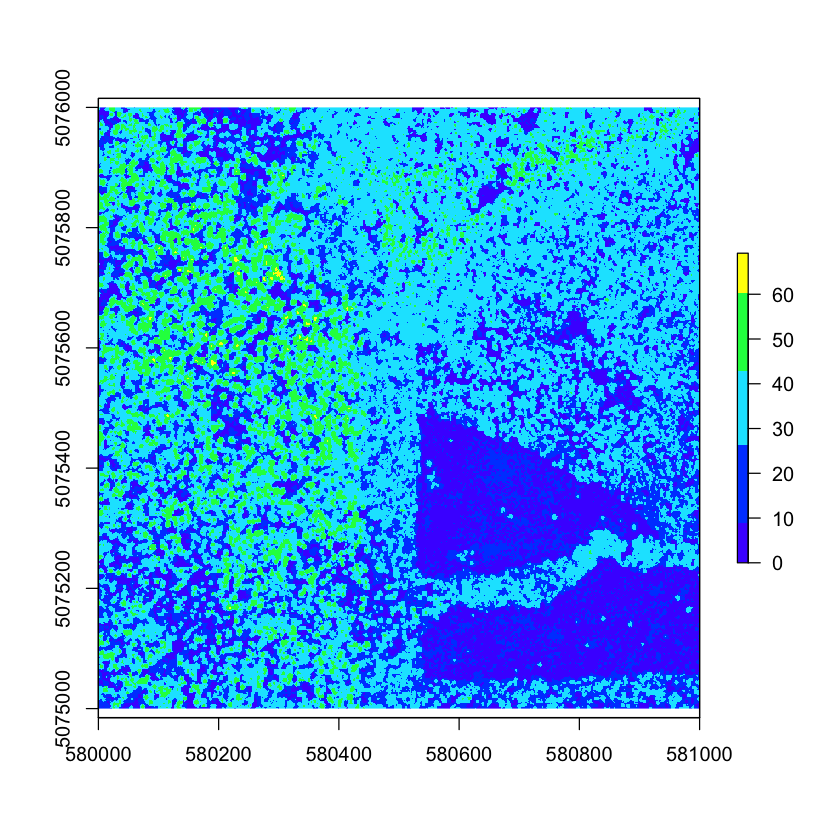

In [26]:
plot(chm, col=topo.colors(5))

### 3. Comparing the two datasets

First, subset the veg structure data to only the individuals that fall 
within this tile, using the `extent()` function from the raster package.

In [ ]:
vegsub <- veg[which(veg$adjEasting >= extent(chm)[1] &
                      veg$adjEasting <= extent(chm)[2] &
                      veg$adjNorthing >= extent(chm)[3] & 
                      veg$adjNorthing <= extent(chm)[4]),]

There are many different ways to approach this comparison! Let's do a 
very simple first pass: use the `extract()` function from the raster 
package to get the CHM value matching the coordinates of each mapped 
plant. Include a buffer equal to the uncertainty in the plant's 
location, and take the highest CHM value within the buffer.

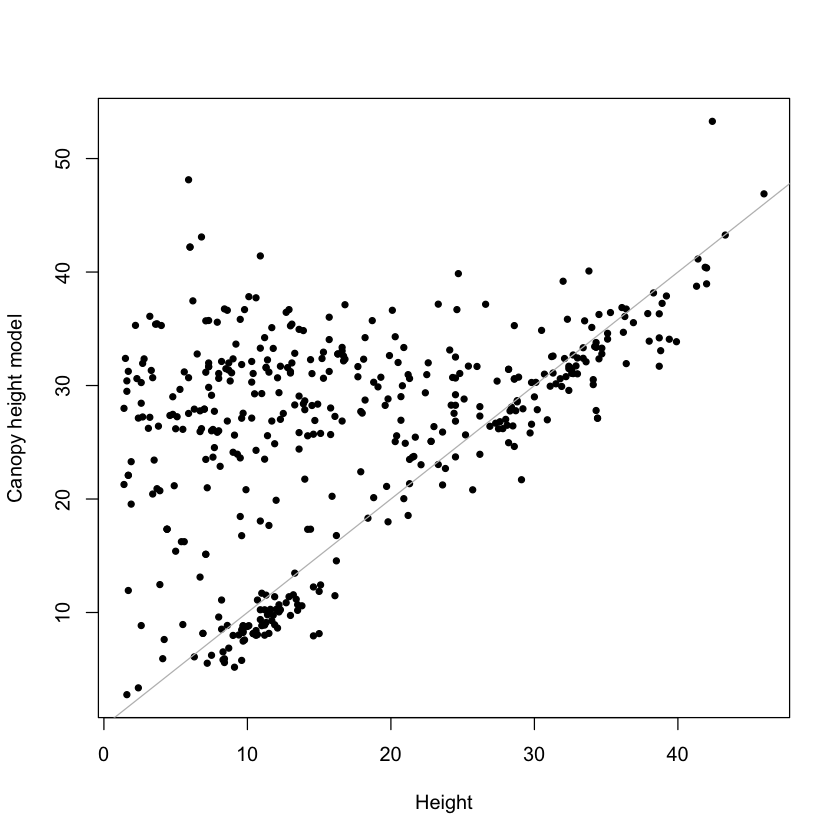

In [27]:
bufferCHM <- extract(chm, cbind(vegsub$adjEasting, 
                                vegsub$adjNorthing),
                     buffer=vegsub$adjCoordinateUncertainty, 
                     fun=max)
plot(bufferCHM~vegsub$height, pch=20, xlab="Height", 
     ylab="Canopy height model")
lines(c(0,50), c(0,50), col="grey")

In [28]:
cor(bufferCHM,vegsub$height, use="complete")

[1] 0.428952897424419

There are a lot of points clustered on the 1-1 line, but there is also a 
cloud of points above the line, where the measured height is lower than 
the canopy height model at the same coordinates. This makes sense, because 
we made no attempt to filter out the understory. There are likely many 
plants measured in the veg structure data that are not at the top of the 
canopy, and the CHM sees only the top of the canopy.

How to exclude understory plants from this analysis? Again, there are many 
possible approaches. I'll show two here, one map-centric and one 
tree-centric.

Starting with the map-centric approach: select a pixel size, and aggregate 
both the veg structure data and the CHM data to find the tallest point in 
each pixel. Let's try this with 10m pixels.

Start by rounding the coordinates of the veg structure data, to create 10m 
bins. Use `floor()` instead of `round()` so each tree ends up in the pixel 
with the same numbering as the raster pixels (the rasters/pixels are 
numbered by their southwest corners).

In [ ]:
easting10 <- 10*floor(vegsub$adjEasting/10)
northing10 <- 10*floor(vegsub$adjNorthing/10)
vegsub <- cbind(vegsub, easting10, northing10)

Use the `aggregate()` function to get the tallest tree in each 10m bin.

In [ ]:
vegbin <- stats::aggregate(vegsub, by=list(vegsub$easting10, vegsub$northing10), FUN=max)

To get the CHM values for the 10m bins, use the `raster` package version 
of the `aggregate()` function.

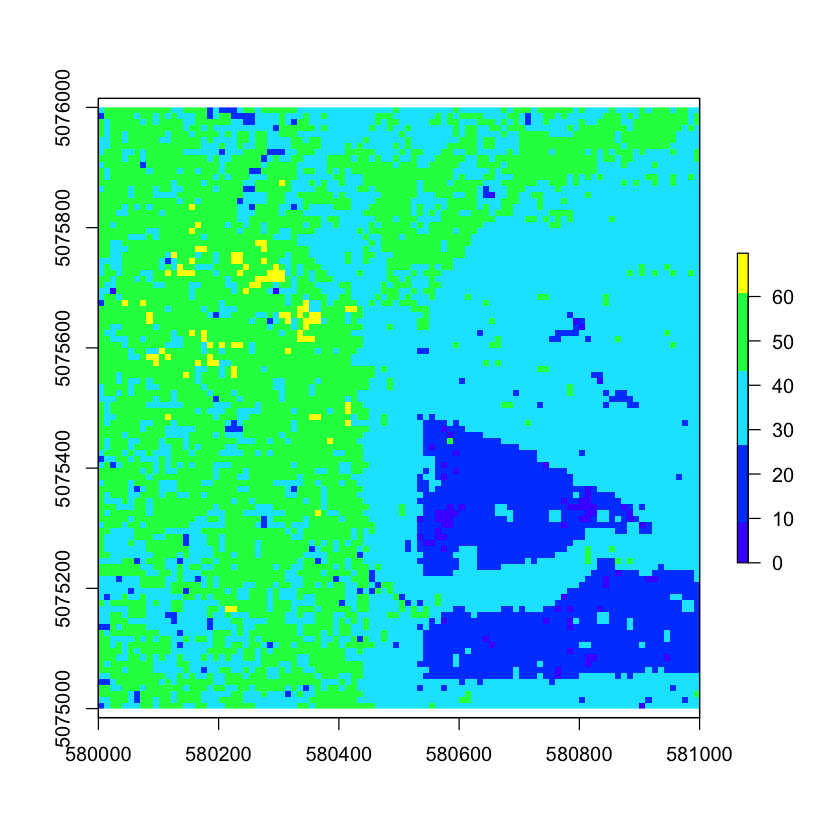

In [29]:
CHM10 <- raster::aggregate(chm, fact=10, fun=max)
plot(CHM10, col=topo.colors(5))

Use the `extract()` function again to get the values from each pixel. We 
don't need a buffer this time, since we've put both datasets onto the same 
grid. But our grids are numbered by the corners, so add 5 to each tree 
coordinate to make sure it's in the correct pixel.

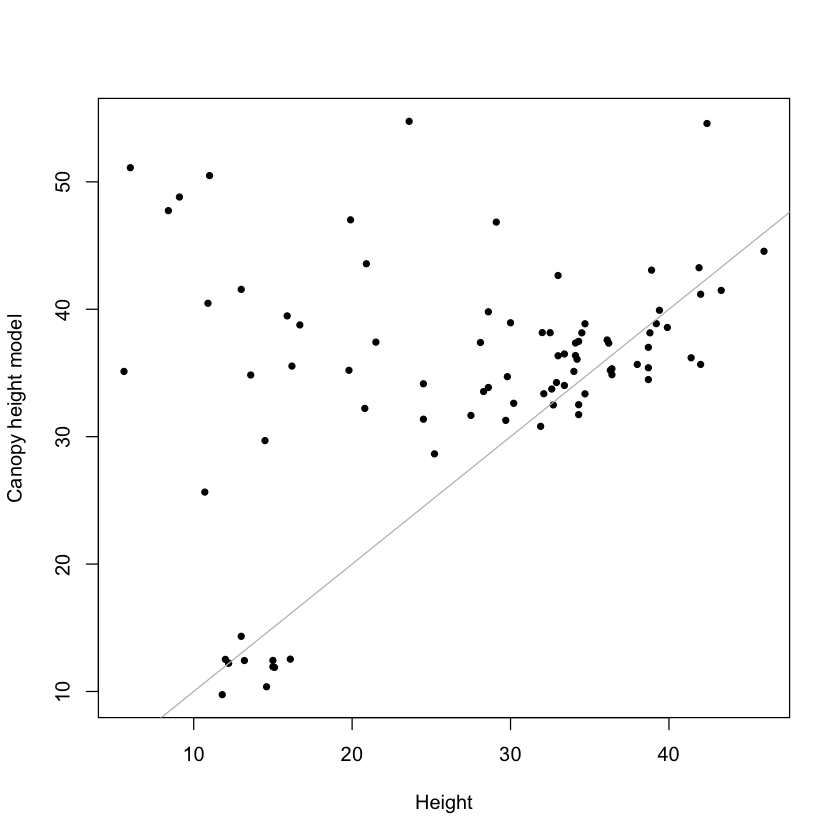

In [30]:
vegbin$easting10 <- vegbin$easting10+5
vegbin$northing10 <- vegbin$northing10+5
binCHM <- extract(CHM10, cbind(vegbin$easting10, 
                               vegbin$northing10))
plot(binCHM~vegbin$height, pch=20, 
     xlab="Height", ylab="Canopy height model")
lines(c(0,50), c(0,50), col="grey")

In [31]:
cor(binCHM, vegbin$height, use="complete")

[1] 0.366996032148528

The understory points are thinned out substantially, but so are the rest. 
We've lost a lot of data by going to a lower resolution.

Let's try and see if we can identify the tallest trees by another approach, 
using the trees as the starting point instead of map area. Start by sorting 
the veg structure data by height.

In [ ]:
vegsub <- vegsub[order(vegsub$height, decreasing=T),]

Now, for each tree, let's estimate which nearby trees might be beneath 
its canopy, and discard those points. To do this:
1. Calculate the distance of each tree from the target tree.
2. Pick a reasonable estimate for canopy size, and discard shorter trees 
within that radius. The radius I used is 0.3 times the height, based on 
some rudimentary googling about Douglas fir allometry. It could definitely 
be improved on!
3. Iterate over all trees.

In [35]:
vegfil <- vegsub
for(i in 1:nrow(vegsub)) {
    if(is.na(vegfil$height[i]))
        next
    dist <- sqrt((vegsub$adjEasting[i]-vegsub$adjEasting)^2 + 
                (vegsub$adjNorthing[i]-vegsub$adjNorthing)^2)
    vegfil$height[which(dist<0.3*vegsub$height[i] & 
                        vegsub$height<vegsub$height[i])] <- NA
}

vegfil <- vegfil[which(!is.na(vegfil$height)),]

Now extract the raster values, as above. Let's also increase the buffer size a bit, to better account for the uncertainty in the Lidar data as well as the uncertainty in the ground locations.

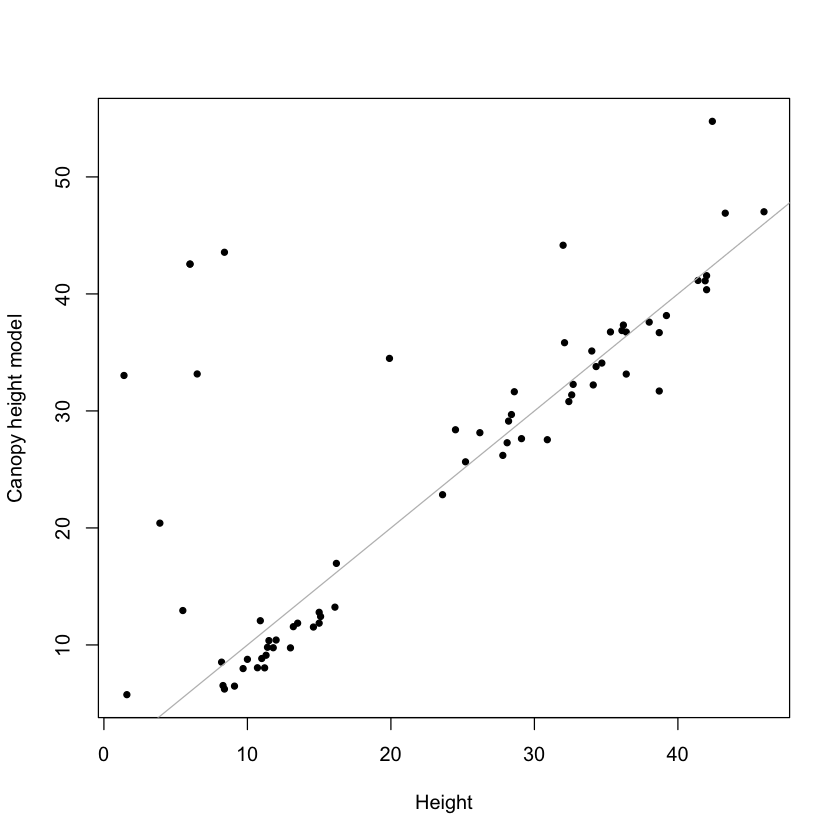

In [36]:
filterCHM <- extract(chm, cbind(vegfil$adjEasting, vegfil$adjNorthing),
                         buffer=vegfil$adjCoordinateUncertainty+1, fun=max)
plot(filterCHM~vegfil$height, pch=20, 
     xlab="Height", ylab="Canopy height model")
lines(c(0,50), c(0,50), col="grey")

In [37]:
cor(filterCHM,vegfil$height)

[1] 0.736503668596511

This is quite a bit better! There are still several understory points we 
failed to exclude, but we were able to filter out most of the understory 
without losing so many overstory points.

Let's try one last thing. The `plantStatus` field in the veg structure data 
indicates whether a plant is dead, broken, or otherwise damaged. In theory, 
a dead or broken tree can still be the tallest thing around, but it's less 
likely, and it's also less likely to get a good Lidar return. Exclude all 
trees that aren't alive:

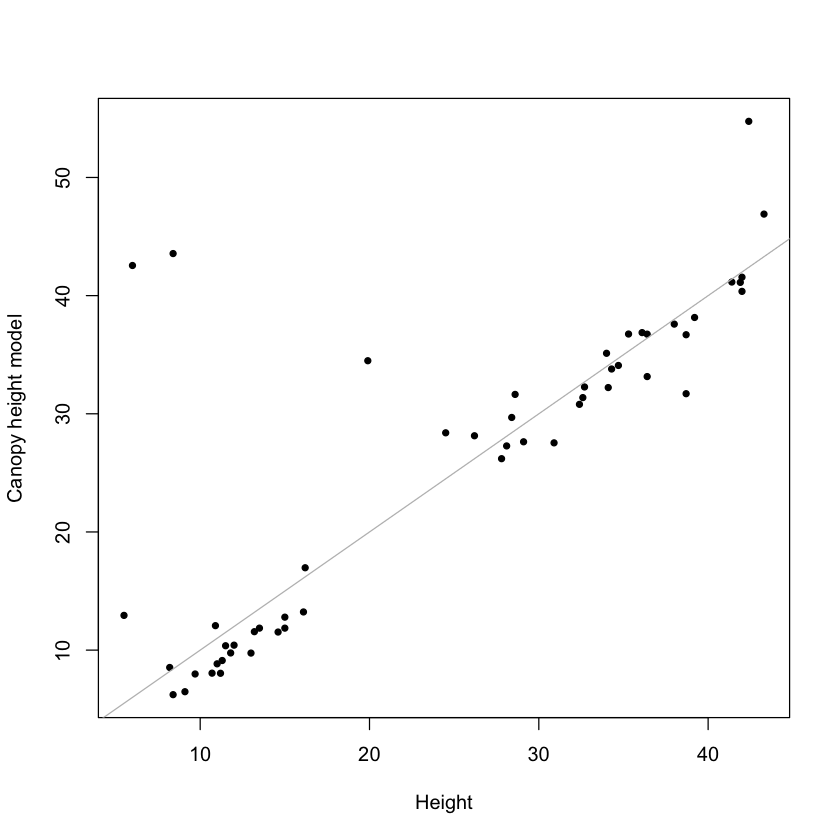

In [38]:
vegfil <- vegfil[which(vegfil$plantStatus=="Live"),]
filterCHM <- extract(chm, cbind(vegfil$adjEasting, vegfil$adjNorthing),
                         buffer=vegfil$adjCoordinateUncertainty+1, fun=max)
plot(filterCHM~vegfil$height, pch=20, 
     xlab="Height", ylab="Canopy height model")
lines(c(0,50), c(0,50), col="grey")

In [39]:
cor(filterCHM,vegfil$height)

[1] 0.819112115567101

Nice!

One final note: however we slice the data, there is a noticeable bias 
even in the strongly correlated values. The CHM heights are generally a 
bit shorter than the ground-based estimates of tree height. There are 
two biases in the CHM data that contribute to this. (1) Lidar returns 
from short-statured vegetation are difficult to distinguish from the 
ground, so the "ground" estimated by Lidar is generally higher than the 
true ground surface, and (2) the height estimate from Lidar represents 
the highest return, but the highest return may slightly miss the actual 
tallest point on a given tree. This is especially likely to happen with 
conifers, which are the top-of-canopy trees at Wind River.